In [9]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style = 'darkgrid')

# read data in 
issues = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2021/2021-03-23/issues.csv', index_col = 0)
roll_calls = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2021/2021-03-23/roll_calls.csv', index_col = 0, na_values=['NA', ''])
unvotes = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2021/2021-03-23/unvotes.csv', index_col = 0)

# print(issues.head(2))
print(issues.index) #'rcid' column
issues = issues.reset_index(drop=False)

# print(roll_calls.head(2))
print(roll_calls.index) #'rcid' column
roll_calls = roll_calls.reset_index(drop=False)

#print(unvotes.head(2))
print(unvotes.index) #'rcid' column
unvotes = unvotes.reset_index(drop=False)

Index([  77, 9001, 9002, 9003, 9004, 9005, 9006,  128,  129,  130,
       ...
       9127, 9128, 9135, 9142, 9136, 9145, 9069, 9074, 9095, 9092],
      dtype='int64', name='rcid', length=5745)
Index([   3,    4,    5,    6,    7,    8,    9,   10,   11,   12,
       ...
       9138, 9139, 9140, 9141, 9142, 9143, 9144, 9145, 9146, 9147],
      dtype='int64', name='rcid', length=6202)
Index([   3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
       ...
       9101, 9101, 9101, 9101, 9101, 9101, 9101, 9101, 9101, 9101],
      dtype='int64', name='rcid', length=869937)


In [2]:
#data checks: issues

"""
rcid is a specific vote session id. 
this table maps the specific topic discussed to a specific vote session id.

note: 

"""
# print("shape: " + str(issues.shape)) #(5745, 3)
# print(issues.describe())
# print(issues.dtypes)
# print(issues.isna().sum()) # no NaN values
# print(issues.duplicated(subset=['rcid', 'short_name']).sum()) # no duplicates on rcid and short_name
# print(issues['short_name'].unique()) # ['me' 'nu' 'di' 'hr' 'co' 'ec']

map_issues = {'me': 'Palestine', 'nu': 'Nuclear', 'di': 'Arms', 'hr': 'Human Rights', 'co': 'Colonialism', 'ec': 'Economic Development'}
issues['short_name'] = issues['short_name'].replace(map_issues)
issues = issues.drop(columns=['issue']).sort_values('rcid') 


#Exploratory Data Analysis
print(issues['short_name'].unique())
summary_issues = issues.groupby('short_name').count().sort_values('rcid', ascending=False)
print(summary_issues)

#Note: some rcids don't have issue tags (i.e not in this dataset), some have multiple.

['Human Rights' 'Economic Development' 'Colonialism' 'Palestine' 'Arms'
 'Nuclear']
                      rcid
short_name                
Arms                  1092
Palestine             1061
Human Rights          1015
Colonialism            957
Nuclear                855
Economic Development   765


In [3]:
#data checks: unvotes

"""
this table describes how each country voted in each voting session. 
"""

# print("shape: " + str(unvotes.shape)) #(869937, 4)
# print(unvotes.describe())
# print(unvotes.dtypes) 
# print(unvotes.isna().sum()) #country code has 7898 missing values 

missing_country = unvotes[unvotes['country_code'].isna()]

# update country codes (present in data cleaning steps on GitHub, written in R)
unvotes['country_code'] = np.where(unvotes['country'] == 'Czechoslovakia', 'CS', unvotes['country_code'])
unvotes['country_code'] = np.where(unvotes['country'] == 'Yugoslavia', 'YU', unvotes['country_code'])
unvotes['country_code'] = np.where(unvotes['country'] == 'German Democratic Republic', 'DD', unvotes['country_code'])
unvotes['country_code'] = np.where(unvotes['country'] == "Yemen People's Republic", 'YD', unvotes['country_code'])

unvotes['country'] = np.where(
    (unvotes['country'].notna()) & (unvotes['country'] == "German Federal Republic"),
    "Federal Republic of Germany",
    unvotes['country']
)

#attach country codes to countries without country codes 
# print(missing_country['country'].unique()) #['Yemen Arab Republic' 'Zanzibar' 'Federal Republic of Germany' 'Namibia']
mapping = {'Yemen Arab Republic': 'YA', 'Zanzibar': 'ZN', 'Federal Republic of Germany': 'WG', 'Namibia': 'NA'}
unvotes['country_code'] = unvotes['country_code'].fillna(unvotes['country'].map(mapping))

# print(unvotes.isna().sum()) # now country code has no missing values
# print(unvotes.duplicated(subset=['rcid', 'country_code']).sum()) # on rcid and country_code, no duplicates

#Exploratory Data Analysis 
#Find proportion of yes, no, abstain votes across all votes
summary_vote = unvotes.groupby('vote').size()
print(summary_vote)

#Find the top few countries likely to vote yes, no and abstain
yes_proportion = pd.DataFrame()
no_proportion = pd.DataFrame()
abstain_proportion = pd.DataFrame()
countries = unvotes['country'].unique()
for country in countries: 
    subset = unvotes[unvotes['country'] == country]
    yes = round(subset[subset['vote'] == 'yes'].shape[0] / subset.shape[0], 2)
    no = round(subset[subset['vote'] == 'no'].shape[0] / subset.shape[0], 2)
    abstain = round(subset[subset['vote'] == 'abstain'].shape[0] / subset.shape[0], 2)

    yes_df = pd.DataFrame({'country': [country], 'proportion': [yes]})
    yes_proportion = pd.concat([yes_proportion, yes_df], axis = 0)
    no_df = pd.DataFrame({'country': [country], 'proportion': [no]})
    no_proportion = pd.concat([no_proportion, no_df], axis = 0)
    abstain_df = pd.DataFrame({'country': [country], 'proportion': [abstain]})
    abstain_proportion = pd.concat([abstain_proportion, abstain_df], axis = 0)

for vote, df in [("yes", yes_proportion), ("no", no_proportion), ("abstain", abstain_proportion)]: 
    df = df.sort_values('proportion', ascending = False)
    print(f"Top 3 countries likely to vote {vote}")
    print(df.head(3))

vote
abstain    110893
no          65500
yes        693544
dtype: int64
Top 3 countries likely to vote yes
               country  proportion
0           Seychelles        0.98
0  São Tomé & Príncipe        0.96
0           Cape Verde        0.95
Top 3 countries likely to vote no
         country  proportion
0  United States        0.50
0         Israel        0.39
0          Palau        0.38
Top 3 countries likely to vote abstain
                       country  proportion
0                     Zanzibar        1.00
0  Federal Republic of Germany        0.42
0                  South Sudan        0.36


In [4]:
#data checks: roll_calls 

"""
this table describes the details of each vote: date, resolution number, descriptions of what the vote is about.
"""

# print(roll_calls.head(1))
# print("shape: " + str(roll_calls.shape)) #(6202, 9)
# print(roll_calls.describe()) #5598/6164 important votes (of those assessed); 2868 amendment votes, 3208 paragraph votes
# print(roll_calls.duplicated(subset=['rcid']).sum()) #no duplicates
# print(roll_calls.isna().sum()) 

"""
missing values: 
importantvote     604
unres             159
amend            3334
para             2994
short             573
descr               1
"""

# print(roll_calls.dtypes) #convert date to DateTime
roll_calls['date'] = pd.to_datetime(roll_calls['date'], format='%Y-%m-%d')
# print(roll_calls.dtypes)

pre_1985 = roll_calls[roll_calls['date'].between('1946-01-01', '1984-12-31')].sort_values('date', ascending=True)
# print(pre_1985.shape[0]) #2844
#print(pre_1985.isna().sum()) #all cleaned except for 151 missing entries for unres

""" 
missing values:
rcid               0
session            0
importantvote      0
date               0
unres            151
amend              0
para               0
short              0
descr              0
"""

post_1985 = roll_calls[roll_calls['date'].between('1985-01-01', '2020-01-01')].sort_values('date', ascending=True)
post_1985 = post_1985.drop(columns=['amend', 'para'])
# print(post_1985.head(1))
# print(post_1985.isna().sum()) #missing entries: 604 importantvote, 8 unres, 573 short, 1 descr

"""
rcid               0
session            0
importantvote    604
date               0
unres              8
short            573
descr              1
"""

pre_no_amend_para = pre_1985[['rcid', 'session', 'importantvote', 'date', 'unres', 'short', 'descr']]
roll_calls_no_amend_para = pd.concat([pre_no_amend_para, post_1985], axis=0)
# print(roll_calls_no_amend_para.shape) #(6202,7) 
# print(roll_calls_no_amend_para.isna().sum()) #missing entries: 604 importantvote, 159 unres, 573 short, 1 descr

At present, we have the following tables: 

issues: --> what kinds of issues are present
- rcid(int): voting number
- short_name(str): type of issue 

unvotes: --> how each country voted on each vote
- rcid(int): voting number
- country(str): country name
- country_code(str): short name of country (2-3 characters)
- vote(str): [yes, no, abstain]

from the roll calls table we have 3 tables: pre_1985, post_1985, roll_calls_no_amend_para
- amend and para were depreciated from 1985. pre_1985 contains them, post_1985 does not. 
- roll_calls_no_amend_para is the roll_calls table without those 2 columns 

- rcid(int): voting number
- session(int): session number, one number can have a lot of votes
- importantvote(int): takes values 0, 1 or NA
- date(DateTime): date
- unres(str): voting code. has missing values. 
- amend(str): whether vote is on amendment.
- para(str): whether vote is on a paragraph
- short(str): short description
- descr(str): long description

In [5]:
#Question: Which countries' votes are most correlated to the overall vote passing? Which country has the highest "success rate"

#update timeframe: 1947-1991
rollcall_cold_war = roll_calls[roll_calls['date'].between('1947-03-12', '1991-12-26')]['rcid']
unvotes = unvotes[unvotes['rcid'].isin(rollcall_cold_war)]

#update unvotes with a column on whether the vote passed or failed
yes_ratio = ((unvotes['vote'] == 'yes').groupby(unvotes['rcid']).mean()).rename('yes') 
no_ratio = ((unvotes['vote'] == 'no').groupby(unvotes['rcid']).mean()).rename('no')
abstain_ratio = ((unvotes['vote'] == 'abstain').groupby(unvotes['rcid']).mean()).rename('abstain')
ratio = pd.concat([yes_ratio, no_ratio, abstain_ratio], axis = 1) #combine horizontally 
unvotes['majority'] = unvotes['rcid'].map(ratio.idxmax(axis=1)) #returns corresponding index with highest value

#merge with short_name column on issues df
correlated = ((unvotes['vote'] == 'yes') & (unvotes['majority'] == 'yes') |
                           (unvotes['vote'] == 'no') & (unvotes['majority'] == 'no') |
                           (unvotes['vote'] == 'abstain') & (unvotes['majority'] == 'abstain')) #returns a Boolean series for each row

#obtain correlation score by country across all issues, across all time
correlation_table = correlated.groupby(unvotes['country']).mean().reset_index(drop=False).rename(columns={0: 'correlation_score'}).sort_values('correlation_score', ascending=False)
correlation_table['correlation_score'] = round(correlation_table['correlation_score'], 2)
correlation_table = correlation_table.reset_index(drop=True)
print(f"Number of countries: {len(correlation_table)}")

countries_of_interest = ['United States', 'China', 'United Kingdom', 'Russia', 'France', 'Singapore']
first_entry = correlation_table.head(3)
filtered_table = correlation_table[correlation_table['country'].isin(countries_of_interest)]
filtered_table_with_first = pd.concat([first_entry, filtered_table], axis = 0)

print(filtered_table_with_first)

Number of countries: 172
            country  correlation_score
0           Vanuatu               0.98
1           Namibia               0.97
2          Djibouti               0.97
60            China               0.89
75        Singapore               0.88
140          Russia               0.68
167  United Kingdom               0.42
168          France               0.42
170   United States               0.36


In [8]:
#Question: For each issue, which country has the highest "success rate" in voting? 

#find the rcids for each issue (using merge instead of mapping and for loop)
unvotes['correlated'] = correlated
unvotes_issues = unvotes.merge(issues, on = 'rcid', how = 'left')

#dataframe with columns: country, issue, score
country_corr_issues = unvotes_issues.groupby(['country', 'short_name'])[['correlated']].mean().sort_values(['short_name', 'correlated'], ascending = [True, False]).reset_index()

#subsetting countries of interest + top 3, but first removing new countries with <5 years in the UN in 1991

#removing new countries
rollcall_88_91 = roll_calls[roll_calls['date'].between('1988-01-01', '1991-12-26')]['rcid']
rollcall_47_87 = roll_calls[roll_calls['date'].between('1947-03-12', '1987-12-31')]['rcid']

countries_in_88_91 = set(unvotes[unvotes['rcid'].isin(rollcall_88_91)]['country'].unique())
countries_in_47_87 = set(unvotes[unvotes['rcid'].isin(rollcall_47_87)]['country'].unique())
new_countries = countries_in_88_91.difference(countries_in_47_87)
country_corr_issues = country_corr_issues[~(country_corr_issues['country'].isin(new_countries))]

#subsetting top 3 + countries of interest
country_corr_issues['rank'] = country_corr_issues.groupby('short_name')['correlated'].rank(method = 'first', ascending = False)
country_corr_issues = country_corr_issues[(country_corr_issues['rank'] <= 3) | (country_corr_issues['country'].isin(countries_of_interest))]

#making top 3 diff colour for plot
country_corr_issues['group'] = 'Countries of Interest'
country_corr_issues.loc[country_corr_issues['rank'] <= 3, 'group'] = 'Top 3'
country_corr_issues

,country,short_name,correlated,rank,group
2,Vanuatu,Arms,0.981273,1.0,Top 3
3,São Tomé & Príncipe,Arms,0.978723,2.0,Top 3
4,Botswana,Arms,0.973615,3.0,Top 3
58,Singapore,Arms,0.923810,56.0,Countries of Interest
133,Russia,Arms,0.750487,130.0,Countries of Interest
139,China,Arms,0.731778,136.0,Countries of Interest
168,United Kingdom,Arms,0.383562,158.0,Countries of Interest
169,France,Arms,0.301181,159.0,Countries of Interest
170,United States,Arms,0.294922,160.0,Countries of Interest
172,China,Colonialism,0.993789,1.0,Top 3


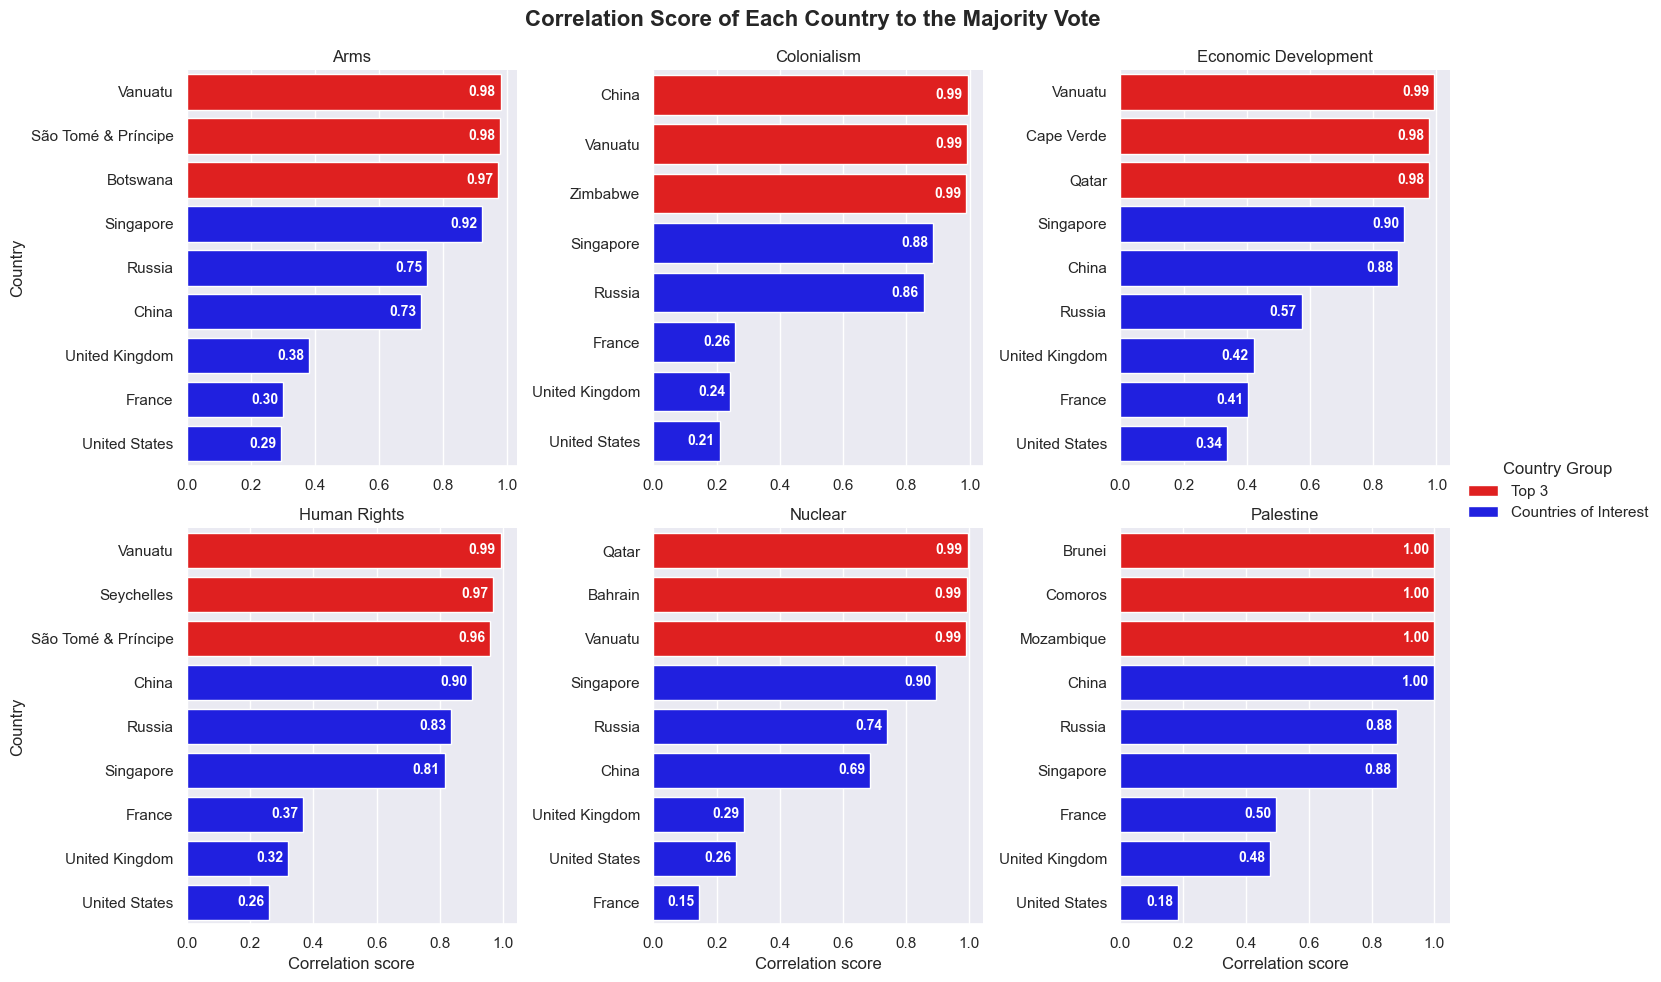

In [10]:
g = sns.catplot(country_corr_issues, kind = 'bar', 
                x = 'correlated', y = 'country', 
                col = 'short_name', col_wrap = 3, 
                sharex = False, sharey = False, hue = 'group', 
                palette = ['red', 'blue'], legend = True)
g.set_axis_labels('Correlation score', 'Country')
g.set_titles('{col_name}')
g.figure.suptitle('Correlation Score of Each Country to the Majority Vote', fontsize = 16, fontweight = 'bold')
g.figure.subplots_adjust(top = 0.92)
g.legend.set_title('Country Group')

for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', fontsize = 10, weight = 'bold', label_type = 'edge', padding = -23, color = 'white')
        
plt.show()

In [9]:
#Question: What is the yes-rate for each issue? 

def rates(subgroup): 
    values = subgroup['vote'].value_counts()
    sum = values.sum()
    yes = round(values.get('yes', 0) / sum, 2)
    no = round(values.get('no', 0) / sum, 2)
    abstain = round(values.get('abstain', 0) / sum, 2)
    return yes, no, abstain 

for key, value in mapping.items(): 
    df = unvotes[unvotes['rcid'].isin(value)]
    yes, no, abstain = rates(df)
    print(f"{key}")
    print(f"Yes: {yes}")
    print(f"No: {no}")
    print(f"Abstain: {abstain} \n")
    

Human Rights
Yes: 0.77
No: 0.07
Abstain: 0.16 

Economic Development
Yes: 0.82
No: 0.06
Abstain: 0.12 

Colonialism
Yes: 0.77
No: 0.08
Abstain: 0.15 

Palestine
Yes: 0.82
No: 0.06
Abstain: 0.12 

Arms
Yes: 0.82
No: 0.05
Abstain: 0.13 

Nuclear
Yes: 0.82
No: 0.05
Abstain: 0.14 

